## Summary of new features and models
New linear regression models:
| Model (Linear Regression)     | Data Type | RMSE  | Pearson CC |
|------------------------------|-----------|-------|------------|
| Detrended Fluctuation Analysis Beta  | Training  | 15.22 | 0.56       |
| Weighted Permutation Entropy Beta | Training  | 18.13 | 0.17       |

Random forest models:
| Model (Random Forest)         | Data Type      | RMSE  | Pearson CC |
|------------------------------|----------------|-------|------------|
| Detrended Fluctuation Analysis Beta     | Training       | 5.61  | 0.96       |
| Sample Entropy Beta      | Training       | 4.73  | 0.97       |
| Sample Entropy Beta     | Testing        | 3.84  | 0.96       |
| Sample Entropy Delta    | Training       | 5.76  | 0.95       |
| Sample Entropy Delta   | Testing        | 4.42  | 0.95       |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyentrp import entropy as ent
import antropy as ant
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load Patient 14 data from text file
eeg_data = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 EEG.txt')

from scipy.signal import butter, filtfilt

# Define band filter
def band_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Sampling frequency = 128 Hz
fs = 128

# Apply filters for each band
delta_band = band_filter(eeg_data, 0.5, 4, fs) # 0.5 to 4 Hz
theta_band = band_filter(eeg_data, 4, 8, fs) # 4 to 8 Hz
alpha_band = band_filter(eeg_data, 8, 13, fs) # 8 to 13 Hz
beta_band = band_filter(eeg_data, 13, 30, fs) # 13 to 30 Hz
gamma_band = band_filter(eeg_data, 30, 63, fs) # 30 to 63 Hz (within Nyquist range)

# Create overlapping 56 s windows of different bands, advancing by 1 s
def moving_window(data, window_size, step_size, fs):
    num_points = len(data)
    window_length = window_size * fs # Length of window in data points
    step_length = step_size * fs # Length of step in data points
    windows = []
    for start in range(0, num_points - window_length + 1, step_length):
        windows.append(data[start:start + window_length])
    return np.array(windows)

window_size = 56 # Length of window in seconds
step_size = 1 # Length of step in seconds
alpha_windows = moving_window(alpha_band, window_size, step_size, fs)
beta_windows = moving_window(beta_band, window_size, step_size, fs)
delta_windows = moving_window(delta_band, window_size, step_size, fs)
theta_windows = moving_window(theta_band, window_size, step_size, fs)
gamma_windows = moving_window(gamma_band, window_size, step_size, fs)

# Load BIS data of Patient 14
patient14_bis = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 BIS.txt')

# Align BIS and PE values by disregarding the first 55 BIS values, as each PE value will represent the end of the window
bis_aligned = patient14_bis[55:55+3001]

# Load Patient 12 data
eeg_data_patient12 = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 12 EEG data.txt')
bis_patient12 = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 12 BIS.txt')

# Apply filters for each band for Patient 12
delta_band_patient12 = band_filter(eeg_data_patient12, 0.5, 4, fs) # 0.5 to 4 Hz
theta_band_patient12 = band_filter(eeg_data_patient12, 4, 8, fs) # 4 to 8 Hz
alpha_band_patient12 = band_filter(eeg_data_patient12, 8, 13, fs) # 8 to 13 Hz
beta_band_patient12 = band_filter(eeg_data_patient12, 13, 30, fs) # 13 to 30 Hz
gamma_band_patient12 = band_filter(eeg_data_patient12, 30, 63, fs) # 30 to 63 Hz (within Nyquist range

# Patient 12 moving windows
alpha_windows_patient12 = moving_window(alpha_band_patient12, window_size, step_size, fs)
beta_windows_patient12 = moving_window(beta_band_patient12, window_size, step_size, fs)
delta_windows_patient12 = moving_window(delta_band_patient12, window_size, step_size, fs)
theta_windows_patient12 = moving_window(theta_band_patient12, window_size, step_size, fs)
gamma_windows_patient12 = moving_window(gamma_band_patient12, window_size, step_size, fs)

# Prepare data
bis_series = pd.Series(bis_aligned, name='BIS')
bis_aligned_patient12 = bis_patient12[55:55+len(beta_windows_patient12)]

Combined Index Equation: BIS = 9.30 * M + 9.45 * SE + 35.22


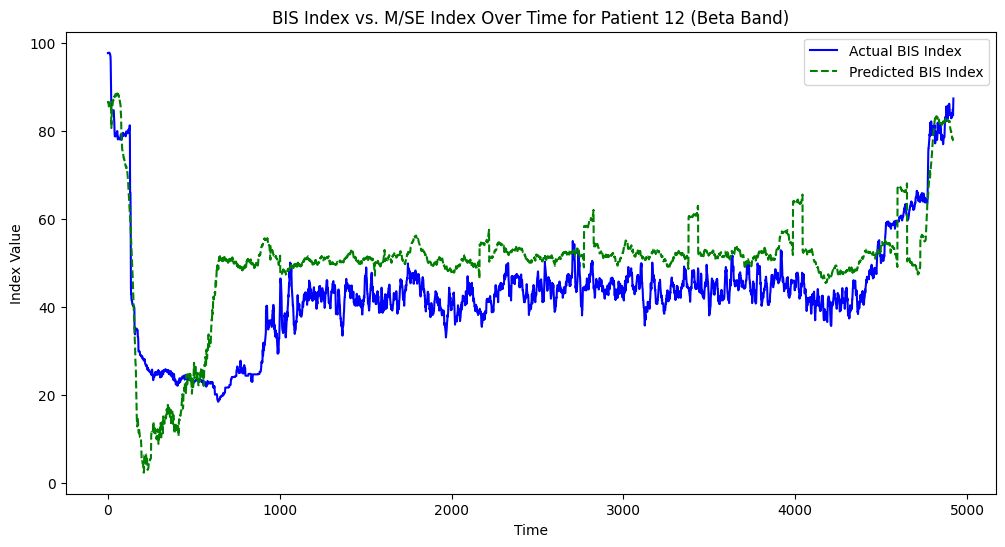

Testing RMSE: 11.292089666936647
Testing Pearson Correlation Coefficient: 0.76150516034181


In [13]:
from sklearn.preprocessing import StandardScaler

# Training data (Patient 14)
mobility_values_beta_train = []  # Replace with Patient 14's mobility beta data
for window in beta_windows:
    m = calculate_mobility(window)
    mobility_values_beta_train.append(m)

mobility_values_beta_train = np.array(mobility_values_beta_train)
se_values_beta_train = np.load('se_values2.npy')
y_train = bis_series  # Replace with BIS values for Patient 14

# Testing data (Patient 12)
mobility_values_beta_test = []
for window in beta_windows_patient12:
    m = calculate_mobility(window)
    mobility_values_beta_test.append(m)

mobility_values_beta_test = np.array(mobility_values_beta_test)
se_values_beta_test = np.load('se_values_patient12.npy')
y_test = bis_aligned_patient12

# Combine features for training and testing
X_train_raw = np.column_stack((mobility_values_beta_train, se_values_beta_train))
X_test_raw = np.column_stack((mobility_values_beta_test, se_values_beta_test))

# Normalize using StandardScaler
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_raw)
X_test_normalized = scaler.transform(X_test_raw)

# Train the model on training data
combined_model = LinearRegression()
combined_model.fit(X_train_normalized, y_train)

# Predict on the test data
combined_bis_test = combined_model.predict(X_test_normalized)

# Get regression coefficients and intercept
coefficients = combined_model.coef_
intercept = combined_model.intercept_

# Output the combined index equation
print(f"Combined Index Equation: BIS = {coefficients[0]:.2f} * M + {coefficients[1]:.2f} * SE + {intercept:.2f}")

# Plot BIS Index vs. Predicted Index for the test data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual BIS Index', color='blue')
plt.plot(combined_bis_test, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. M/SE Index Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate RMSE and Pearson correlation coefficient for the test data
rmse_combined_test = np.sqrt(mean_squared_error(y_test, combined_bis_test))
correlation_combined_test, _ = stats.pearsonr(combined_bis_test, y_test)

print(f"Testing RMSE: {rmse_combined_test}")
print(f"Testing Pearson Correlation Coefficient: {correlation_combined_test}")


Combined Index Equation: BIS = 6.99 * M1 + 7.66 * SE + 43.35


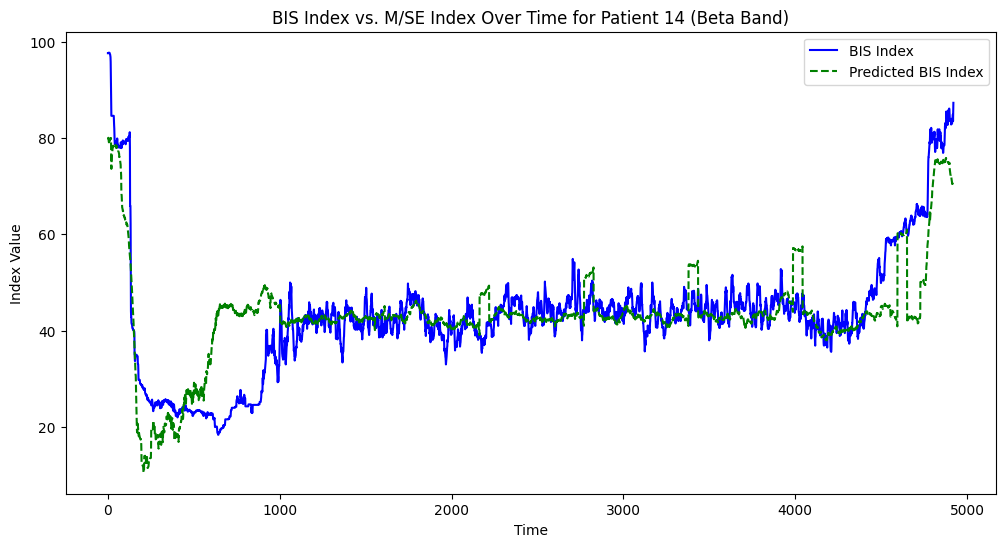

M/SE Beta Training Model RMSE:  8.015966759560483
M/SE Beta Training Model Pearson CC:  0.785044361257168


In [12]:
from sklearn.preprocessing import StandardScaler

# Calculate mobility of given dataset
def calculate_mobility(signal):
    first_derivative = np.diff(signal, 1)
    variance = np.var(signal)
    variance_first_derivative = np.var(first_derivative)
    mobility = np.sqrt(variance_first_derivative / variance)
    return mobility

# Calculate mobility for each second
mobility_values_beta = []
for window in beta_windows_patient12:
    m = calculate_mobility(window)
    mobility_values_beta.append(m)

mobility_values_beta = np.array(mobility_values_beta)
se_values_beta = np.load('se_values_patient12.npy')

# Normalise mobility and PE
features = np.column_stack((mobility_values_beta, se_values_beta))
scaler = StandardScaler()
normalised_features = scaler.fit_transform(features)

M_index_norm_beta = normalised_features[:, 0]
SE_index_norm_beta = normalised_features[:, 1]

X_combined_beta = np.column_stack((M_index_norm_beta, SE_index_norm_beta))
y_combined_beta = bis_aligned_patient12

# Initialize and fit the linear regression model
combined_model_beta = LinearRegression()
combined_model_beta.fit(X_combined_beta, y_combined_beta)

# Predict the BIS index using the learned model
combined_bis_beta = combined_model_beta.predict(X_combined_beta)

# Get the regression coefficients and intercept
coefficients = combined_model_beta.coef_
intercept = combined_model_beta.intercept_

# Output the combined index equation
print(f"Combined Index Equation: BIS = {coefficients[0]:.2f} * M1 + {coefficients[1]:.2f} * SE + {intercept:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(combined_bis_beta, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. M/SE Index Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined_beta = np.sqrt(mean_squared_error(bis_aligned_patient12, combined_bis_beta))
print("M/SE Beta Training Model RMSE: ", rmse_combined_beta)

# Calculate Pearson correlation coefficient
correlation_combined_beta, _ = stats.pearsonr(combined_bis_beta, bis_aligned_patient12)
print("M/SE Beta Training Model Pearson CC: ", correlation_combined_beta)

DFA Index Equation: BIS = -622.231399292855 * DFA1 + 96.67452344736832


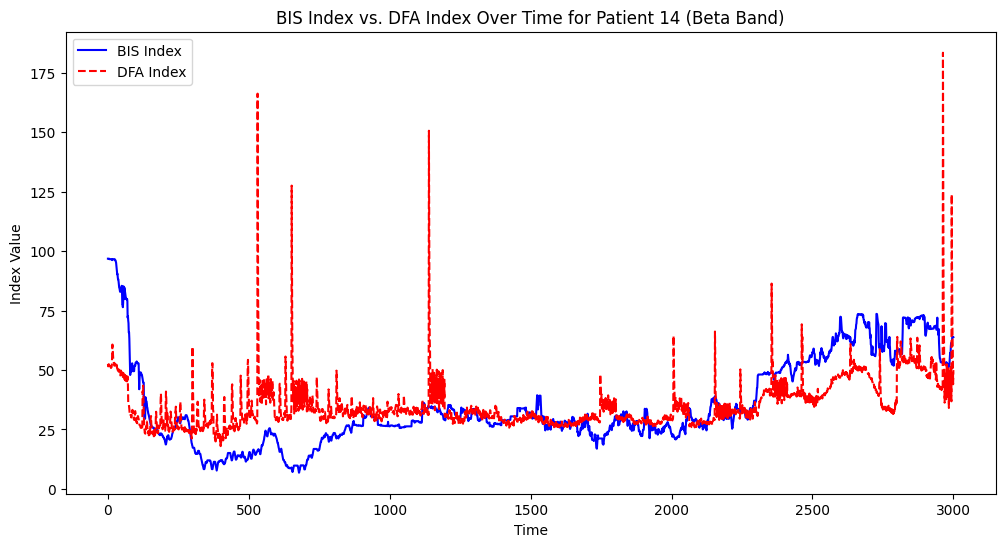

DFA Beta Training Model RMSE:  15.224094598683758
DFA Beta Training Model Pearson CC:  0.56165616833775


In [2]:
import antropy as ant

dfa_values_beta = []
for window in beta_windows:
    dfa = ant.detrended_fluctuation(window)
    dfa_values_beta.append(dfa)

dfa_values_beta = np.array(dfa_values_beta)

# Create the DFA index for beta band
dfa_df_beta = pd.DataFrame(dfa_values_beta, columns=['DFA']) # Convert DFA numpy array to pandas DataFrame
DFA_beta = dfa_df_beta.values.reshape(-1, 1)
DFA_model_beta = LinearRegression()
DFA_model_beta.fit(DFA_beta, bis_series)
DFA_index_beta = DFA_model_beta.predict(DFA_beta)

# Calculate the regression coefficients
k_DFA_beta = DFA_model_beta.coef_[0]
b_DFA_beta = DFA_model_beta.intercept_
print(f"DFA Index Equation: BIS = {k_DFA_beta} * DFA1 + {b_DFA_beta}")

# Plot BIS Index vs. DFA Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(DFA_index_beta, label='DFA Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. DFA Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_dfa_beta = np.sqrt(mean_squared_error(bis_series, DFA_index_beta))
print("DFA Beta Training Model RMSE: ", rmse_dfa_beta)

# Calculate Pearson correlation coefficient
correlation_dfa_beta, _ = stats.pearsonr(bis_series, DFA_index_beta)
print("DFA Beta Training Model Pearson CC: ", correlation_dfa_beta)

WPE Index Equation: BIS = 95143.52103003861 * WPE1 + -95106.38082247757


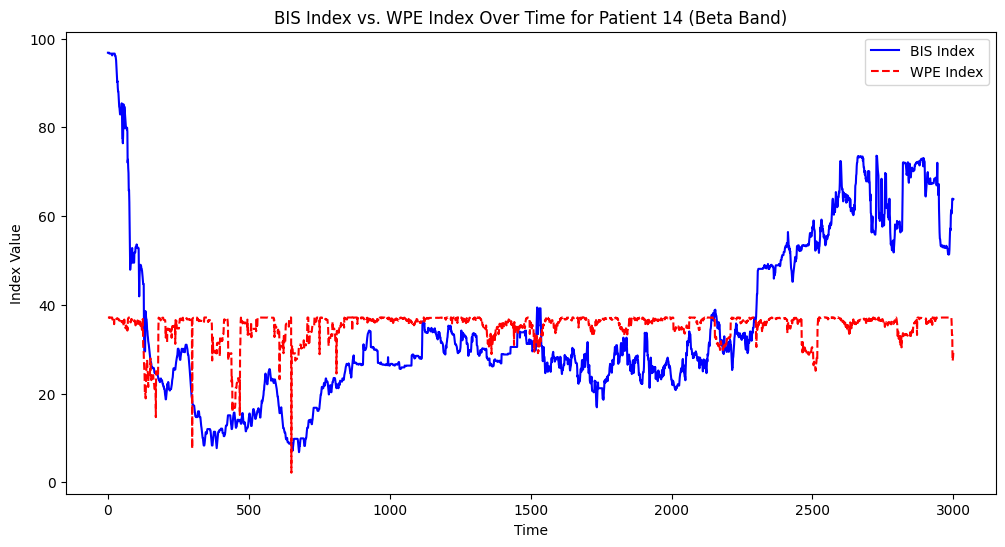

WPE Beta Training Model RSME:  18.12732165151398
WPE Beta Training Model Pearson CC:  0.17169633381947327


In [3]:
def time_delay_embedding(time_series, embedding_dimension, delay):
    """
    !!! Borrowed from pyentropy library.
    Calculate time-delayed embedding.

    Parameters
    ----------
    time_series : np.ndarray
        The input time series, shape (n_times)
    embedding_dimension : int
        The embedding dimension (order).
    delay : int
        The delay between embedded points.

    Returns
    -------
    embedded : ndarray
        The embedded time series with shape (n_times - (order - 1) * delay, order).

    """
    series_length = len(time_series)
    embedded_series = np.empty((embedding_dimension, series_length - (embedding_dimension - 1) * delay))
    for i in range(embedding_dimension):
        embedded_series[i] = time_series[i * delay : i * delay + embedded_series.shape[1]]
    return embedded_series.T
    
def weighted_permutation_entropy(time_series, order=2, delay=1, normalize=False):
    """
    !!! Borrowed from pyentropy library.
    Calculate the weighted permutation entropy.

    Weighted permutation entropy captures the information in the amplitude of a signal where
    standard permutation entropy only measures the information in the ordinal pattern, "motif".

    Parameters
    ----------
    time_series : list | np.ndarray
        Time series
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.

    Returns
    -------
    wpe : float
        Weighted Permutation Entropy

    References
    ----------
    .. [1] Bilal Fadlallah, Badong Chen, Andreas Keil, and José Príncipe
           Phys. Rev. E 87, 022911 - Published 20 February 2013

    Notes
    -----
    - Updated in Jun 2023 by Nikolay Donets
    - Updated in March 2021 by Samuel Dotson (samgdotson@gmail.com)

    Examples
    --------
    1. Weighted permutation entropy with order 2

        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value between 0 and log2(factorial(order))
        >>> print(permutation_entropy(x, order=2))
            0.912

    2. Normalized weighted permutation entropy with order 3

        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(permutation_entropy(x, order=3, normalize=True))
            0.547

    """
    x = time_delay_embedding(time_series, embedding_dimension=order, delay=delay)

    weights = np.var(x, axis=1)
    sorted_idx = x.argsort(kind="quicksort", axis=1)

    motif_weights = {}
    for weight, indices in zip(weights, sorted_idx):  # noqa: B905
        motif = tuple(indices)
        if motif in motif_weights:
            motif_weights[motif] += weight
        else:
            motif_weights[motif] = weight

    pw = np.array(list(motif_weights.values()))
    pw /= weights.sum()

    b = np.log2(pw)
    wpe = -np.dot(pw, b)

    if normalize:
        wpe /= np.log2(math.factorial(order))

    return wpe

wpe_values_beta = []
for window in beta_windows:
    wpe = weighted_permutation_entropy(window, 2)
    wpe_values_beta.append(wpe)

wpe_values_beta = np.array(wpe_values_beta)

# Create the WPE index for beta band
wpe_df_beta = pd.DataFrame(wpe_values_beta, columns=['WPE']) # Convert WPE numpy array to pandas DataFrame
WPE_beta = wpe_df_beta.values.reshape(-1, 1)
WPE_model_beta = LinearRegression()
WPE_model_beta.fit(WPE_beta, bis_series)
WPE_index_beta = WPE_model_beta.predict(WPE_beta)

# Calculate the regression coefficients
k_WPE_beta = WPE_model_beta.coef_[0]
b_WPE_beta = WPE_model_beta.intercept_
print(f"WPE Index Equation: BIS = {k_WPE_beta} * WPE1 + {b_WPE_beta}")

# Plot BIS Index vs. WPE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(WPE_index_beta, label='WPE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. WPE Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RSME)
rsme_wpe_beta = np.sqrt(mean_squared_error(bis_series, WPE_index_beta))
print("WPE Beta Training Model RSME: ", rsme_wpe_beta)

# Calculate Pearson correlation coefficient
correlation_wpe_beta, _ = stats.pearsonr(bis_series, WPE_index_beta)
print("WPE Beta Training Model Pearson CC: ", correlation_wpe_beta)

DFA Index Equation (Ridge): BIS = -281.81933501492347 * DFA + 63.05463054189975


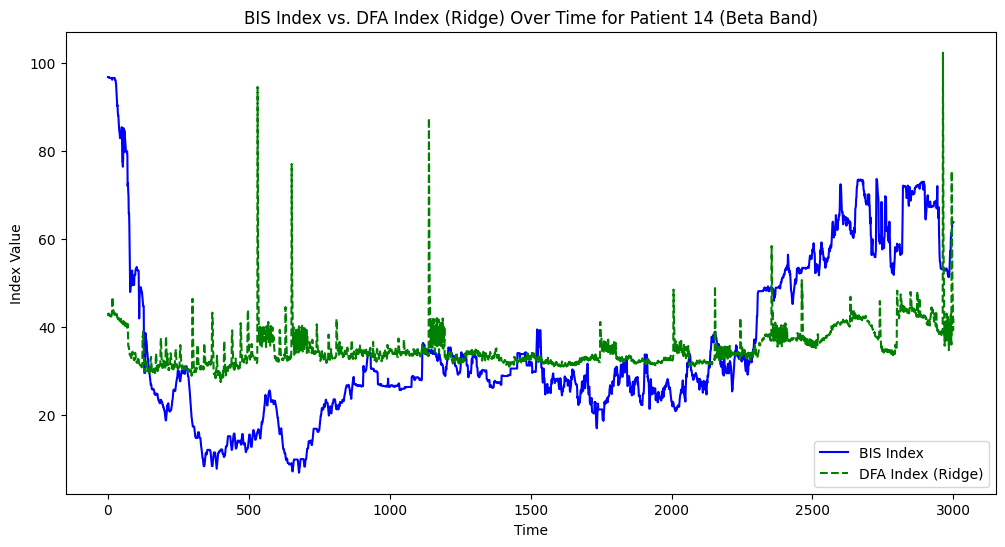

In [4]:
from sklearn.linear_model import Ridge

# Create and fit the model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(DFA_beta, bis_series)
DFA_index_beta_ridge = ridge_model.predict(DFA_beta)

# Calculate the regression coefficients
k_DFA_beta_ridge = ridge_model.coef_[0]
b_DFA_beta_ridge = ridge_model.intercept_
print(f"DFA Index Equation (Ridge): BIS = {k_DFA_beta_ridge} * DFA + {b_DFA_beta_ridge}")

# Plot BIS Index vs. DFA Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(DFA_index_beta_ridge, label='DFA Index (Ridge)', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. DFA Index (Ridge) Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()


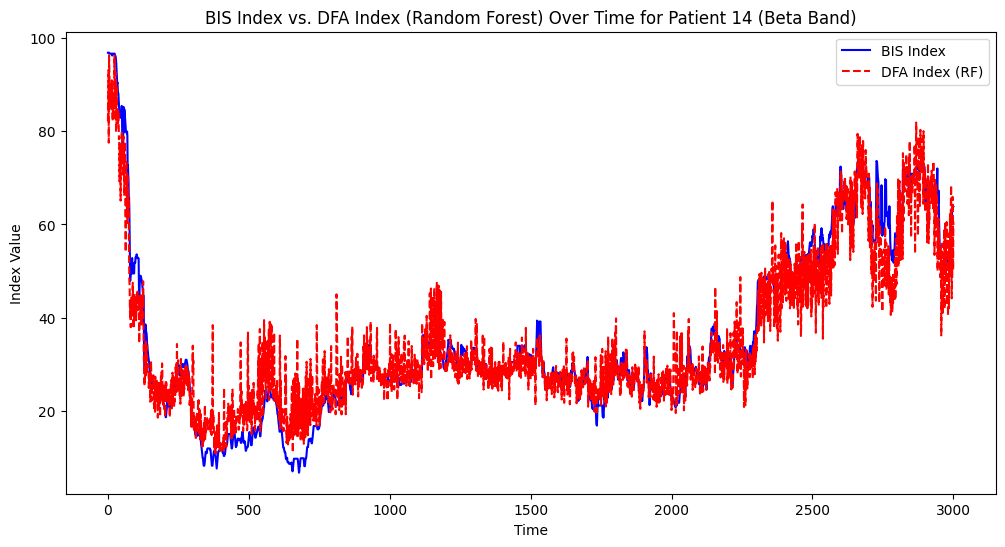

DFA Beta Training Model RMSE (Random Forest):  5.605732800754709
DFA Beta Training Model Pearson CC (Random Forest):  0.9563858809166543


In [5]:
from sklearn.ensemble import RandomForestRegressor

# Create and fit the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(DFA_beta, bis_series)
DFA_index_beta_rf = rf_model.predict(DFA_beta)

# Plot BIS Index vs. DFA Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(DFA_index_beta_rf, label='DFA Index (RF)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. DFA Index (Random Forest) Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_dfa_beta_rf = np.sqrt(mean_squared_error(bis_series, DFA_index_beta_rf))
print("DFA Beta Training Model RMSE (Random Forest): ", rmse_dfa_beta_rf)

# Calculate Pearson correlation coefficient
correlation_dfa_beta_rf, _ = stats.pearsonr(bis_series, DFA_index_beta_rf)
print("DFA Beta Training Model Pearson CC (Random Forest): ", correlation_dfa_beta_rf)

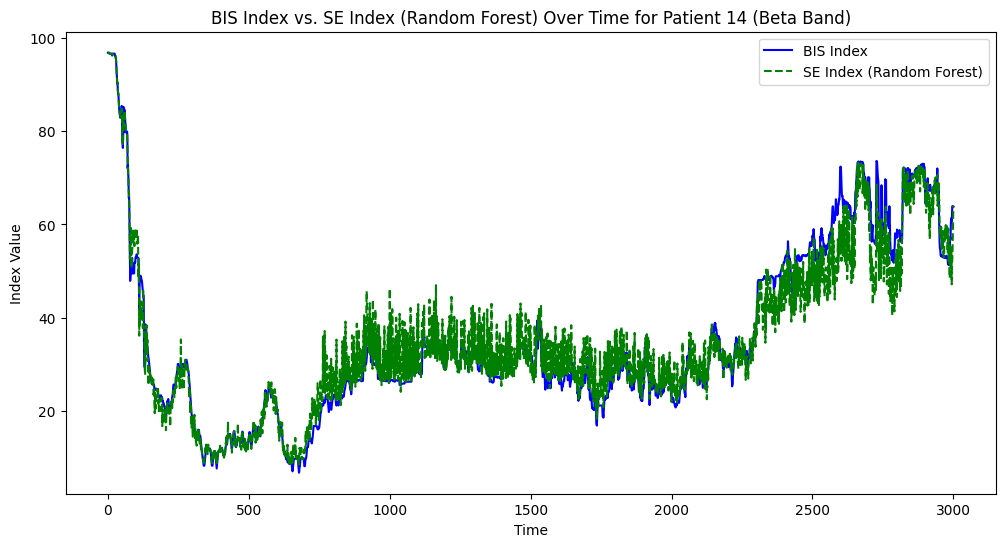

SE Beta Training Model RMSE (Random Forest):  4.734113108495159
SE Beta Training Model Pearson CC (Random Forest):  0.9679595502116545


In [6]:
from sklearn.ensemble import RandomForestRegressor

# Load sample entropy values of beta band
se_values_beta = np.load('se_values2.npy')

# Create the SE index
se_df_beta = pd.DataFrame(se_values_beta, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE_beta = se_df_beta.values.reshape(-1, 1)

# Fit the Random Forest model
rf_model_beta = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_beta.fit(SE_beta, bis_series)
SE_index_beta_rf = rf_model_beta.predict(SE_beta)

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(SE_index_beta_rf, label='SE Index (Random Forest)', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index (Random Forest) Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_beta_rf = np.sqrt(mean_squared_error(SE_index_beta_rf, bis_series))
print("SE Beta Training Model RMSE (Random Forest): ", rmse_se_beta_rf)

# Calculate Pearson correlation coefficient
correlation_se_beta_rf, _ = stats.pearsonr(SE_index_beta_rf, bis_series)
print("SE Beta Training Model Pearson CC (Random Forest): ", correlation_se_beta_rf)


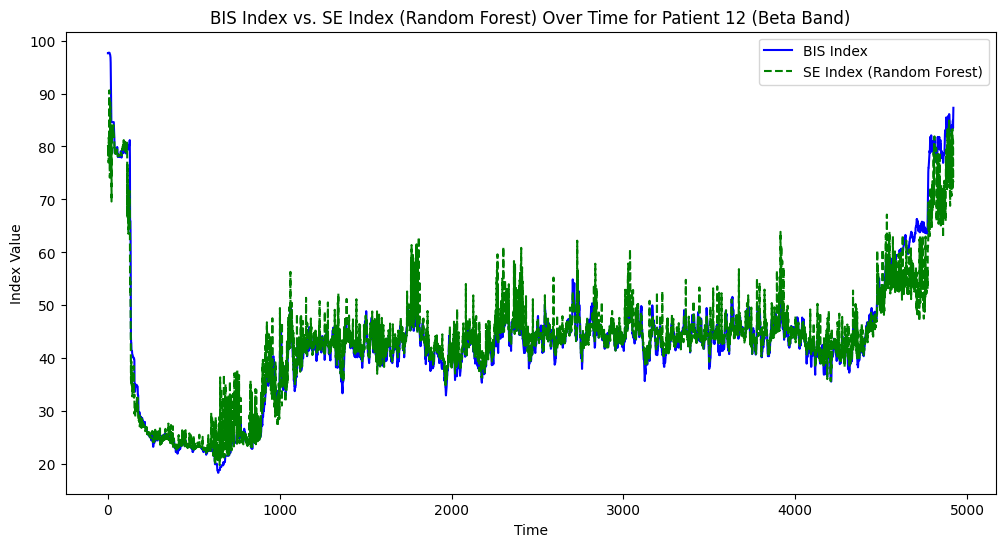

SE Beta Testing Model RMSE (Random Forest):  3.838041761179518
SE Beta Testing Model Pearson CC (Random Forest):  0.9585826875847171


In [7]:
# Load sample entropy values of beta band for Patient 12
se_values_beta_patient12 = np.load('se_values_patient12.npy')

# Create the SE index
se_df_beta_patient12 = pd.DataFrame(se_values_beta_patient12, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE_beta_patient12 = se_df_beta_patient12.values.reshape(-1, 1)

# Fit the Random Forest model
rf_model_beta_patient12 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_beta_patient12.fit(SE_beta_patient12, bis_aligned_patient12)
SE_index_beta_patient12_rf = rf_model_beta_patient12.predict(SE_beta_patient12)

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(SE_index_beta_patient12_rf, label='SE Index (Random Forest)', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index (Random Forest) Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_beta_patient12_rf = np.sqrt(mean_squared_error(SE_index_beta_patient12_rf, bis_aligned_patient12))
print("SE Beta Testing Model RMSE (Random Forest): ", rmse_se_beta_patient12_rf)

# Calculate Pearson correlation coefficient
correlation_se_beta_patient12_rf, _ = stats.pearsonr(SE_index_beta_patient12_rf, bis_aligned_patient12)
print("SE Beta Testing Model Pearson CC (Random Forest): ", correlation_se_beta_patient12_rf)

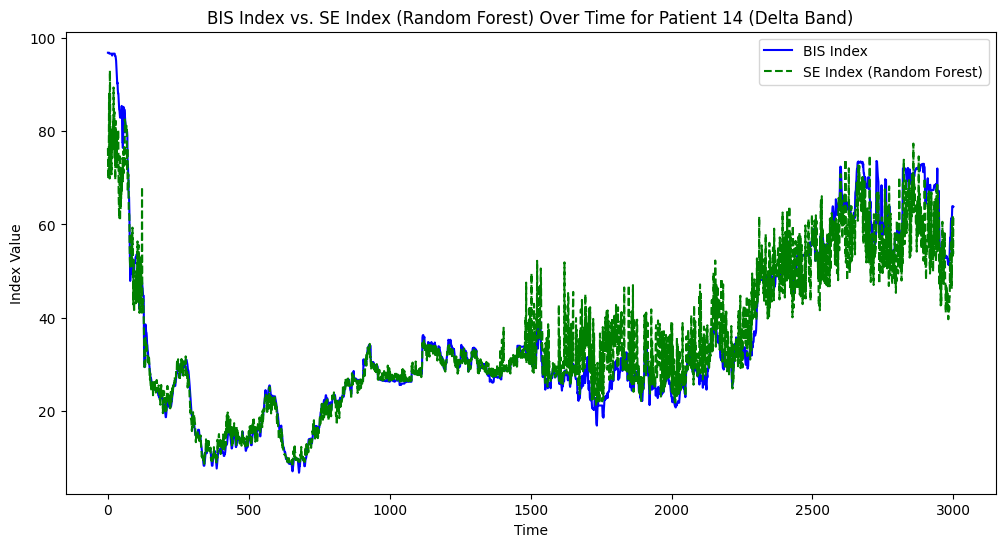

SE Delta Training Model RMSE (Random Forest):  5.764546598404041
SE Delta Training Model Pearson CC (Random Forest):  0.9540647283716112


In [8]:
# Load sample entropy values of delta band
se_values_delta = np.load('se_values_delta.npy')

# Create the SE index
se_df_delta = pd.DataFrame(se_values_delta, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE_delta = se_df_delta.values.reshape(-1, 1)

# Fit the Random Forest model
rf_model_delta = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_delta.fit(SE_delta, bis_series)
SE_index_delta_rf = rf_model_delta.predict(SE_delta)

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(SE_index_delta_rf, label='SE Index (Random Forest)', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index (Random Forest) Over Time for Patient 14 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_delta_rf = np.sqrt(mean_squared_error(SE_index_delta_rf, bis_series))
print("SE Delta Training Model RMSE (Random Forest): ", rmse_se_delta_rf)

# Calculate Pearson correlation coefficient
correlation_se_delta_rf, _ = stats.pearsonr(SE_index_delta_rf, bis_series)
print("SE Delta Training Model Pearson CC (Random Forest): ", correlation_se_delta_rf)

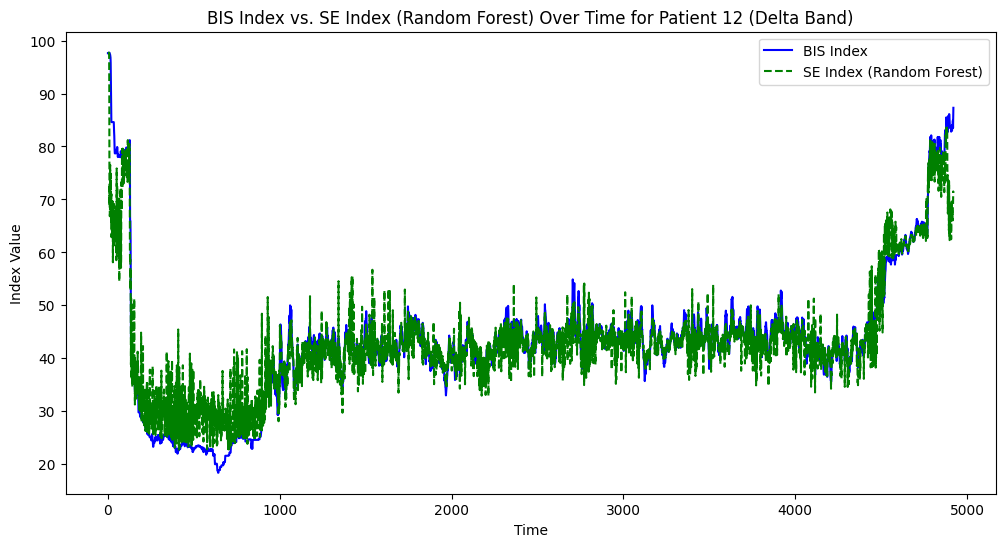

SE Delta Testing Model RMSE (Random Forest):  4.418928248704998
SE Delta Testing Model Pearson CC (Random Forest):  0.9465994215070264


In [9]:
# Load sample entropy values of delta band for Patient 12
se_values_delta_patient12 = np.load('se_values_delta_patient12.npy')

# Create the SE index
se_df_delta_patient12 = pd.DataFrame(se_values_delta_patient12, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE_delta_patient12 = se_df_delta_patient12.values.reshape(-1, 1)

# Fit the Random Forest model
rf_model_delta_patient12 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_delta_patient12.fit(SE_delta_patient12, bis_aligned_patient12)
SE_index_delta_patient12_rf = rf_model_delta_patient12.predict(SE_delta_patient12)

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(SE_index_delta_patient12_rf, label='SE Index (Random Forest)', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index (Random Forest) Over Time for Patient 12 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_delta_patient12_rf = np.sqrt(mean_squared_error(SE_index_delta_patient12_rf, bis_aligned_patient12))
print("SE Delta Testing Model RMSE (Random Forest): ", rmse_se_delta_patient12_rf)

# Calculate Pearson correlation coefficient
correlation_se_delta_patient12_rf, _ = stats.pearsonr(SE_index_delta_patient12_rf, bis_aligned_patient12)
print("SE Delta Testing Model Pearson CC (Random Forest): ", correlation_se_delta_patient12_rf)